Take a look at the [repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) for more information

In [ ]:
# Depth2Image with CycleGAN
# ========================
# This notebook adapts the CycleGAN implementation for depth-to-image translation
# using the dataset Borcherding/Depth2Anthing_RobotAnnotations_v1 from Hugging Face.

# %% [markdown]
# ## Setup Environment

# Install

In [2]:
# %%
# Install required packages
!pip install -q datasets zipfile36 huggingface_hub torch torchvision dominate visdom opencv-python

In [3]:
# Clone the CycleGAN repository
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

fatal: destination path 'pytorch-CycleGAN-and-pix2pix' already exists and is not an empty directory.


In [4]:
# Install repository requirements
%cd pytorch-CycleGAN-and-pix2pix/
!pip install -r requirements.txt
%cd ..

m:\PHOTO_HDD_AUTUMN_GAN\depth2anythingGAN_v2\notebookData\pytorch-CycleGAN-and-pix2pix
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
m:\PHOTO_HDD_AUTUMN_GAN\depth2anythingGAN_v2\notebookData


In [5]:
# %% [markdown]
# ## Download and Prepare Dataset

# %%
import os
import random
import zipfile
import shutil
import glob
import tempfile
from tqdm.auto import tqdm
import requests
from huggingface_hub import hf_hub_download, list_repo_files

c:\Users\ADA\miniconda3\envs\imgAnno2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def create_directory_structure():
    print("Creating directory structure...")
    os.makedirs('datasets/depth2image/trainA', exist_ok=True)  # depth images for training
    os.makedirs('datasets/depth2image/trainB', exist_ok=True)  # original images for training
    os.makedirs('datasets/depth2image/testA', exist_ok=True)   # depth images for testing
    os.makedirs('datasets/depth2image/testB', exist_ok=True)   # original images for testing
    print("Directory structure created.")

In [7]:
def clone_and_organize_dataset(test_split=0.1):
    """
    Clone the dataset repository directly and organize it for CycleGAN
    """
    print("Cloning the Hugging Face dataset repository...")

    # Create a directory for the cloned repo
    os.makedirs('hf_dataset', exist_ok=True)

    # Clone the repository
    clone_cmd = "git clone https://huggingface.co/datasets/Borcherding/Depth2Anything_RobotAnnotations_v2 hf_dataset"
    os.system(clone_cmd)

    # Check if clone was successful
    if not os.path.exists('hf_dataset'):
        print("Failed to clone the repository.")
        return False

    print("Repository cloned successfully. Organizing dataset...")

    # Create CycleGAN directory structure
    os.makedirs('datasets/depth2image/trainA', exist_ok=True)  # depth images
    os.makedirs('datasets/depth2image/trainB', exist_ok=True)  # original images
    os.makedirs('datasets/depth2image/testA', exist_ok=True)   # test depth images
    os.makedirs('datasets/depth2image/testB', exist_ok=True)   # test original images

    # Look for all depth images and their corresponding originals
    depth_images = glob.glob('hf_dataset/**/*__depth.png', recursive=True)
    print(f"Found {len(depth_images)} depth images")

    # Match with original images
    matched_pairs = []
    for depth_img in depth_images:
        # Get the base filename without '__depth.png'
        basename = os.path.basename(depth_img).replace('__depth.png', '')

        # Look for the matching original image
        dirname = os.path.dirname(depth_img)
        original_img = os.path.join(dirname, f"{basename}_.png")

        if os.path.exists(original_img):
            matched_pairs.append((depth_img, original_img))

    print(f"Found {len(matched_pairs)} matching image pairs")

    if len(matched_pairs) == 0:
        # If no matches found with this pattern, try to explore the dataset structure
        print("No matching pairs found with the expected naming pattern. Exploring dataset structure...")

        # List all files to understand dataset organization
        all_files = glob.glob('hf_dataset/**/*', recursive=True)
        print("Sample of files found:")
        for file in all_files[:10]:  # Show first 10 files
            print(f"  {file}")

        return False

    # Split into train and test sets
    random.shuffle(matched_pairs)
    test_size = max(1, int(len(matched_pairs) * test_split))
    test_pairs = matched_pairs[:test_size]
    train_pairs = matched_pairs[test_size:]

    print(f"Split dataset into {len(train_pairs)} training pairs and {len(test_pairs)} testing pairs")

    # Copy training files
    print("Copying training files...")
    for i, (depth_file, original_file) in enumerate(tqdm(train_pairs)):
        shutil.copy(depth_file, f'datasets/depth2image/trainA/{i:05d}.png')
        shutil.copy(original_file, f'datasets/depth2image/trainB/{i:05d}.png')

    # Copy testing files
    print("Copying testing files...")
    for i, (depth_file, original_file) in enumerate(tqdm(test_pairs)):
        shutil.copy(depth_file, f'datasets/depth2image/testA/{i:05d}.png')
        shutil.copy(original_file, f'datasets/depth2image/testB/{i:05d}.png')

    print("Dataset organization complete!")

    # Verify results
    print("\nVerifying dataset organization...")
    for dir_path in ['datasets/depth2image/trainA', 'datasets/depth2image/trainB',
                     'datasets/depth2image/testA', 'datasets/depth2image/testB']:
        if os.path.exists(dir_path):
            files = os.listdir(dir_path)
            print(f"{dir_path}: {len(files)} files")

    return True

In [8]:
def extract_local_zip_and_organize(test_split=0.1):
    """
    Extract the zip file from the cloned repository and organize the dataset
    """
    print("Extracting zip file from cloned repository...")

    # Check if the zip file exists in the cloned repository
    zip_path = os.path.join('hf_dataset', 'robotsV2Zip.zip')
    if not os.path.exists(zip_path):
        print(f"Zip file not found at {zip_path}")
        return False

    print(f"Found zip file at {zip_path}")

    # Create temp directory for extraction
    temp_dir = tempfile.mkdtemp()
    print(f"Extracting to {temp_dir}")

    try:
        # Extract the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

        print("Extraction complete. Scanning for images...")

        # Check the extracted content
        depth_images = []
        original_images = []

        for root, _, files in os.walk(temp_dir):
            for file in files:
                if file.endswith('__depth.png'):
                    depth_images.append(os.path.join(root, file))
                elif file.endswith('_.png'):
                    original_images.append(os.path.join(root, file))

        print(f"Found {len(depth_images)} depth images and {len(original_images)} original images")

        if len(depth_images) == 0 or len(original_images) == 0:
            # Try different file patterns if the expected ones aren't found
            print("Trying alternative file patterns...")

            # List all image files to understand naming patterns
            all_images = []
            for root, _, files in os.walk(temp_dir):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        all_images.append(os.path.join(root, file))

            print(f"Found {len(all_images)} total image files")
            if len(all_images) > 0:
                print("Sample image filenames:")
                for img in all_images[:10]:  # Show first 10 images
                    print(f"  {os.path.basename(img)}")

            # If there are image files but not matching our patterns, we could try to infer the patterns
            # For now, let's just use all image files and split them evenly if we have enough
            if len(all_images) >= 20:  # Arbitrary minimum number for a useful dataset
                print("Using all images found and splitting them between depth and original")

                # Sort to ensure consistent results
                all_images.sort()

                # Assume first half are depth, second half are originals
                # This is a fallback assumption and might not be correct for all datasets
                half_point = len(all_images) // 2
                depth_images = all_images[:half_point]
                original_images = all_images[half_point:2*half_point]

                # Ensure equal counts
                min_count = min(len(depth_images), len(original_images))
                depth_images = depth_images[:min_count]
                original_images = original_images[:min_count]

                print(f"Using {len(depth_images)} pairs of images")

                # Create matched pairs
                matched_pairs = list(zip(depth_images, original_images))
            else:
                print("Not enough images found to create a dataset")
                shutil.rmtree(temp_dir)
                return False
        else:
            # Match depth and original images by base name
            depth_basenames = [os.path.basename(f).replace('__depth.png', '') for f in depth_images]
            original_basenames = [os.path.basename(f).replace('_.png', '') for f in original_images]

            # Find common files
            common_basenames = set(depth_basenames).intersection(set(original_basenames))
            print(f"Found {len(common_basenames)} matching image pairs")

            # Get file paths for matched pairs
            matched_pairs = []
            for basename in common_basenames:
                depth_file = next(f for f in depth_images if basename in os.path.basename(f))
                original_file = next(f for f in original_images if basename in os.path.basename(f))
                matched_pairs.append((depth_file, original_file))

        # Determine test set size
        test_size = max(1, int(len(matched_pairs) * test_split))

        # Split into train and test sets
        random.shuffle(matched_pairs)
        test_pairs = matched_pairs[:test_size]
        train_pairs = matched_pairs[test_size:]

        print(f"Split dataset into {len(train_pairs)} training pairs and {len(test_pairs)} testing pairs")

        # Copy files to appropriate directories
        print("Copying training files...")
        for i, (depth_file, original_file) in enumerate(tqdm(train_pairs)):
            shutil.copy(depth_file, f'datasets/depth2image/trainA/{i:05d}.png')
            shutil.copy(original_file, f'datasets/depth2image/trainB/{i:05d}.png')

        print("Copying testing files...")
        for i, (depth_file, original_file) in enumerate(tqdm(test_pairs)):
            shutil.copy(depth_file, f'datasets/depth2image/testA/{i:05d}.png')
            shutil.copy(original_file, f'datasets/depth2image/testB/{i:05d}.png')

        print("Dataset organization complete")

        # Clean up
        shutil.rmtree(temp_dir)
        print("Temporary files removed")
        return True

    except Exception as e:
        print(f"Error processing zip file: {e}")
        # Clean up
        shutil.rmtree(temp_dir)
        return False

In [9]:
def organize_dataset():
    """Organize the dataset using multiple approaches"""
    # Create directory structure
    create_directory_structure()

    # Try git cloning the repository first
    if clone_and_organize_dataset():
        print("Successfully organized dataset using git clone")
    # Try extracting the zip file from the cloned repository if the organization fails
    elif extract_local_zip_and_organize():
        print("Successfully organized dataset by extracting the local zip file")
    # Try downloading and extracting zip files if the above methods fail
    elif download_and_extract_dataset():
        print("Successfully organized dataset from downloaded zip files")
    # If that fails, try downloading images directly
    elif download_direct_images():
        print("Successfully organized dataset from direct image downloads")
    else:
        print("Failed to organize dataset. Please try downloading the files manually.")

    # Verify results
    print("\nVerifying dataset organization...")
    for dir_path in ['datasets/depth2image/trainA', 'datasets/depth2image/trainB',
                     'datasets/depth2image/testA', 'datasets/depth2image/testB']:
        if os.path.exists(dir_path):
            files = os.listdir(dir_path)
            print(f"{dir_path}: {len(files)} files")
        else:
            print(f"{dir_path} does not exist")

In [10]:
# Execute dataset organization
organize_dataset()

Creating directory structure...
Directory structure created.
Cloning the Hugging Face dataset repository...
Repository cloned successfully. Organizing dataset...
Found 0 depth images
Found 0 matching image pairs
No matching pairs found with the expected naming pattern. Exploring dataset structure...
Sample of files found:
  hf_dataset\README.md
  hf_dataset\robotsV2Zip.zip
Extracting zip file from cloned repository...
Found zip file at hf_dataset\robotsV2Zip.zip
Extracting to C:\Users\ADA\AppData\Local\Temp\tmpjpg351wt
Extraction complete. Scanning for images...
Found 765 depth images and 765 original images
Found 765 matching image pairs
Split dataset into 689 training pairs and 76 testing pairs
Copying training files...


100%|██████████| 689/689 [00:13<00:00, 49.62it/s]


Copying testing files...


100%|██████████| 76/76 [00:01<00:00, 51.25it/s]


Dataset organization complete
Temporary files removed
Successfully organized dataset by extracting the local zip file

Verifying dataset organization...
datasets/depth2image/trainA: 689 files
datasets/depth2image/trainB: 689 files
datasets/depth2image/testA: 76 files
datasets/depth2image/testB: 76 files


In [11]:
# %% [markdown]
# ## Train CycleGAN Model
#
# This will train a CycleGAN model to convert depth images (A) to realistic images (B).
# The training process may take several hours depending on your hardware.

# %%
# Change directory to repository
%cd pytorch-CycleGAN-and-pix2pix/

m:\PHOTO_HDD_AUTUMN_GAN\depth2anythingGAN_v2\notebookData\pytorch-CycleGAN-and-pix2pix


In [12]:
# Train CycleGAN model
# Feel free to adjust parameters like batch size, number of epochs, etc.
# For faster training on Colab, consider reducing n_epochs and n_epochs_decay
!python train.py \
    --dataroot ../datasets/depth2image \
    --name depth2image \
    --model cycle_gan \
    --display_id -1 \
    --n_epochs 25 \
    --n_epochs_decay 25 \
    --batch_size 4 \
    --save_epoch_freq 5

----------------- Options ---------------
               batch_size: 4                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ../datasets/depth2image       	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest             

c:\Users\ADA\miniconda3\envs\imgAnno2\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [13]:
# After training, copy the model for testing (with error handling)
import os
import shutil

source_path = './checkpoints/depth2image/latest_net_G_A.pth'
target_path = './checkpoints/depth2image/latest_net_G.pth'

# First check if the checkpoint directory exists
if not os.path.exists('./checkpoints/depth2image/'):
    os.makedirs('./checkpoints/depth2image/', exist_ok=True)
    print("Created checkpoints directory")

# Check if source model exists
if os.path.exists(source_path):
    shutil.copy(source_path, target_path)
    print(f"Successfully copied {source_path} to {target_path}")
else:
    print(f"Source model file {source_path} not found!")
    # Look for alternative model files
    import glob
    model_files = glob.glob('./checkpoints/depth2image/*.pth')
    if model_files:
        print("Found these model files instead:")
        for file in model_files:
            print(f"  {os.path.basename(file)}")
        # Try to use a suitable alternative if available
        for file in model_files:
            if 'G_A' in file or 'G.pth' in file:
                shutil.copy(file, target_path)
                print(f"Copied alternative model {file} to {target_path}")
                break
    else:
        print("No model files found in checkpoint directory. Training may not have completed.")

print("Model preparation complete.")

Successfully copied ./checkpoints/depth2image/latest_net_G_A.pth to ./checkpoints/depth2image/latest_net_G.pth
Model preparation complete.


In [27]:
# Test the model in both directions with improved error handling
import os
import glob

def test_model_direction(is_depth_to_image=True):
    """
    Test the model in one direction
    is_depth_to_image: If True, test A->B (depth to image), otherwise test B->A (image to depth)
    """
    # Determine directories and model suffix based on direction
    if is_depth_to_image:
        test_data_path = '../datasets/depth2image/testA'
        model_suffix = '_AtoB'
        direction = 'AtoB'
        results_dir = '../results/depth2image/AtoB'
        description = "Depth to Image"
    else:
        test_data_path = '../datasets/depth2image/testB'
        model_suffix = '_BtoA'
        direction = 'BtoA'
        results_dir = '../results/depth2image/BtoA'
        description = "Image to Depth"
    
    # Ensure the results directory exists
    os.makedirs(results_dir, exist_ok=True)
    
    # Check if test data exists
    if not os.path.exists(test_data_path) or len(os.listdir(test_data_path)) == 0:
        print(f"WARNING: Test data not found at {test_data_path} or directory is empty")
        return False
    else:
        print(f"Found {len(os.listdir(test_data_path))} test images for {description} conversion")
    
    # Check if model exists - handling different naming conventions
    if is_depth_to_image:
        # Try both naming conventions (AtoB and _A)
        model_path = './checkpoints/depth2image/latest_net_G_A.pth'  # G_A is for A->B (depth->image)
    else:
        # For B->A direction (image->depth)
        model_path = './checkpoints/depth2image/latest_net_G_B.pth'  # G_B is for B->A (image->depth)
    if not os.path.exists(model_path):
        print(f"WARNING: Model file not found at {model_path}")
        # Look for any model file we could use
        model_files = glob.glob('./checkpoints/depth2image/*.pth')
        if model_files:
            print("Found these model files instead:")
            for file in model_files:
                print(f"  {os.path.basename(file)}")
        else:
            print("No model files found in checkpoint directory")
    
    # Run the test with full path information
    print(f"\nRunning model test for {description} conversion...")
    
    # Different implementation may use different naming conventions
    # In this implementation, G_A generates B from A (depth->image), and G_B generates A from B (image->depth)
    # IMPORTANT: The model_suffix should NOT include a leading underscore as the filename already has one
    if is_depth_to_image:
        model_suffix_actual = '_A'  # Use G_A for depth->image
    else:
        model_suffix_actual = '_B'  # Use G_B for image->depth
        
    # For debugging - print the expected model path
    print(f"Looking for model at: ./checkpoints/depth2image/latest_net_G{model_suffix_actual}.pth")
        
    !python test.py \
        --dataroot {os.path.abspath(test_data_path)} \
        --name depth2image \
        --model test \
        --no_dropout \
        --results_dir {os.path.abspath(results_dir)} \
        --model_suffix {model_suffix_actual} \
        --direction {direction}
    
    # Check if results were generated
    result_files = glob.glob(f'{results_dir}/**/*.png', recursive=True)
    print(f"\nFound {len(result_files)} result images for {description} conversion")
    if result_files:
        print("Sample results:")
        for file in result_files[:5]:
            print(f"  {os.path.relpath(file)}")
        return True
    else:
        print(f"No result images were found for {description} conversion. Test may have failed.")
        return False

# Test both directions
print("Testing depth to image conversion (A->B)")
depth_to_image_success = test_model_direction(is_depth_to_image=True)

print("\n" + "="*50 + "\n")

print("Testing image to depth conversion (B->A)")
image_to_depth_success = test_model_direction(is_depth_to_image=False)

# Report overall success
if depth_to_image_success and image_to_depth_success:
    print("\nBoth directions successfully tested!")
elif depth_to_image_success:
    print("\nOnly depth to image conversion worked successfully.")
elif image_to_depth_success:
    print("\nOnly image to depth conversion worked successfully.")
else:
    print("\nBoth tests failed. Please check model and data.")

# Visualize Results
# Let's display some of the results
def show_results(is_depth_to_image=True, num_samples=3):
    print(f"\nShowing results for {'depth to image' if is_depth_to_image else 'image to depth'} conversion")
    
    # Determine directory based on direction
    if is_depth_to_image:
        results_dir = '../results/depth2image/AtoB'
    else:
        results_dir = '../results/depth2image/BtoA'
    
    # Get all result images - adjust the pattern to match actual output
    fake_images = glob.glob(f'{results_dir}/test_latest/images/*_fake_B.png')
    real_images = glob.glob(f'{results_dir}/test_latest/images/*_real_A.png')
    
    if len(fake_images) == 0 or len(real_images) == 0:
        # Try alternative pattern
        fake_images = glob.glob(f'{results_dir}/test_latest/images/*_fake.png')
        real_images = glob.glob(f'{results_dir}/test_latest/images/*_real.png')
    
    if len(fake_images) == 0 or len(real_images) == 0:
        # For image to depth case, check for fake_A
        fake_images = glob.glob(f'{results_dir}/test_latest/images/*_fake_A.png')
    
    # Print the paths to help debug
    print(f"Searching for result images...")
    print(f"Found {len(fake_images)} fake images and {len(real_images)} real images")
    
    if len(fake_images) == 0 or len(real_images) == 0:
        print("No result images found. Let's search the filesystem to locate them:")
        # Search all possibilities
        all_png = glob.glob(f'{results_dir}/**/*.png', recursive=True)
        print(f"Found {len(all_png)} PNG files in results directory")
        if len(all_png) > 0:
            print("Sample paths:")
            for path in all_png[:5]:
                print(f"  {path}")
        return
    
    # Take a few samples
    samples = min(num_samples, min(len(fake_images), len(real_images)))
    for i in range(samples):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        real_path = real_images[i]
        fake_path = fake_images[i]
        
        real_img = plt.imread(real_path)
        fake_img = plt.imread(fake_path)
        
        if is_depth_to_image:
            ax1.set_title('Input (Depth Image)')
            ax2.set_title('Output (Generated Image)')
        else:
            ax1.set_title('Input (Original Image)')
            ax2.set_title('Output (Generated Depth Image)')
        
        ax1.imshow(real_img)
        ax1.axis('off')
        
        ax2.imshow(fake_img)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

# Show results for both directions
if depth_to_image_success:
    show_results(is_depth_to_image=True)
if image_to_depth_success:
    show_results(is_depth_to_image=False)

Testing depth to image conversion (A->B)
Found 76 test images for Depth to Image conversion

Running model test for Depth to Image conversion...
Looking for model at: ./checkpoints/depth2image/latest_net_G_A.pth
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: m:\PHOTO_HDD_AUTUMN_GAN\depth2anythingGAN_v2\notebookData\datasets\depth2image\testA	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02       

In [28]:
# %% [markdown]
# ## Visualize Results
#
# Let's display some of the results - comparing input depth images to generated realistic images.

# %%
import matplotlib.pyplot as plt
import glob
import random

def show_results(num_samples=5):
    # Get all result images - adjust the pattern to match actual output
    fake_images = glob.glob('../results/depth2image/depth2image/test_latest/images/*_fake_B.png')
    real_images = glob.glob('../results/depth2image/depth2image/test_latest/images/*_real_A.png')

    if len(fake_images) == 0 or len(real_images) == 0:
        # Try alternative paths
        fake_images = glob.glob('../results/depth2image/test_latest/images/*_fake_B.png')
        real_images = glob.glob('../results/depth2image/test_latest/images/*_real_A.png')

    if len(fake_images) == 0 or len(real_images) == 0:
        # Try one more pattern
        fake_images = glob.glob('../results/depth2image/depth2image/test_latest/images/*_fake.png')
        real_images = glob.glob('../results/depth2image/depth2image/test_latest/images/*_real.png')

    # Print the paths to help debug
    print(f"Searching for result images...")
    print(f"Found {len(fake_images)} fake images and {len(real_images)} real images")

    if len(fake_images) == 0 or len(real_images) == 0:
        print("No result images found. Let's search the filesystem to locate them:")
        # Search all possibilities
        all_png = glob.glob('../results/**/*.png', recursive=True)
        print(f"Found {len(all_png)} PNG files in results directory")
        if len(all_png) > 0:
            print("Sample paths:")
            for path in all_png[:5]:
                print(f"  {path}")
        return

    # Extract basenames for matching
    fake_base = [os.path.basename(f).split('_fake')[0] for f in fake_images]
    real_base = [os.path.basename(r).split('_real')[0] for r in real_images]

    # Find common base names
    common = list(set(fake_base).intersection(set(real_base)))

    if not common:
        print("No matching pairs found. File naming patterns may be different.")
        # Try to use available images anyway
        samples = min(num_samples, min(len(fake_images), len(real_images)))
        for i in range(samples):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

            real_path = real_images[i]
            fake_path = fake_images[i]

            real_img = plt.imread(real_path)
            fake_img = plt.imread(fake_path)

            ax1.imshow(real_img)
            ax1.set_title('Input (Depth Image)')
            ax1.axis('off')

            ax2.imshow(fake_img)
            ax2.set_title('Output (Generated Image)')
            ax2.axis('off')

            plt.tight_layout()
            plt.show()
        return

    # Select random samples
    samples = random.sample(common, min(num_samples, len(common)))

    # Display pairs
    for i, sample in enumerate(samples):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Find the corresponding files
        real_path = next((r for r in real_images if sample in os.path.basename(r)), None)
        fake_path = next((f for f in fake_images if sample in os.path.basename(f)), None)

        if real_path and fake_path:
            real_img = plt.imread(real_path)
            fake_img = plt.imread(fake_path)

            ax1.imshow(real_img)
            ax1.set_title('Input (Depth Image)')
            ax1.axis('off')

            ax2.imshow(fake_img)
            ax2.set_title('Output (Generated Image)')
            ax2.axis('off')

            plt.tight_layout()
            plt.show()

Searching for result images...
Found 50 fake images and 50 real images


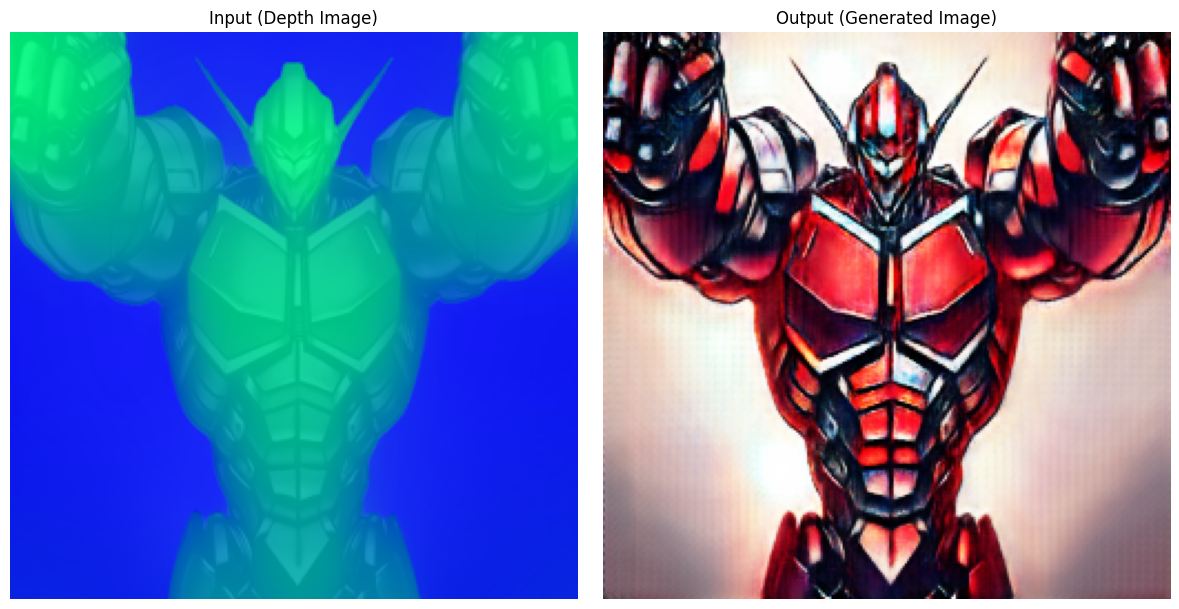

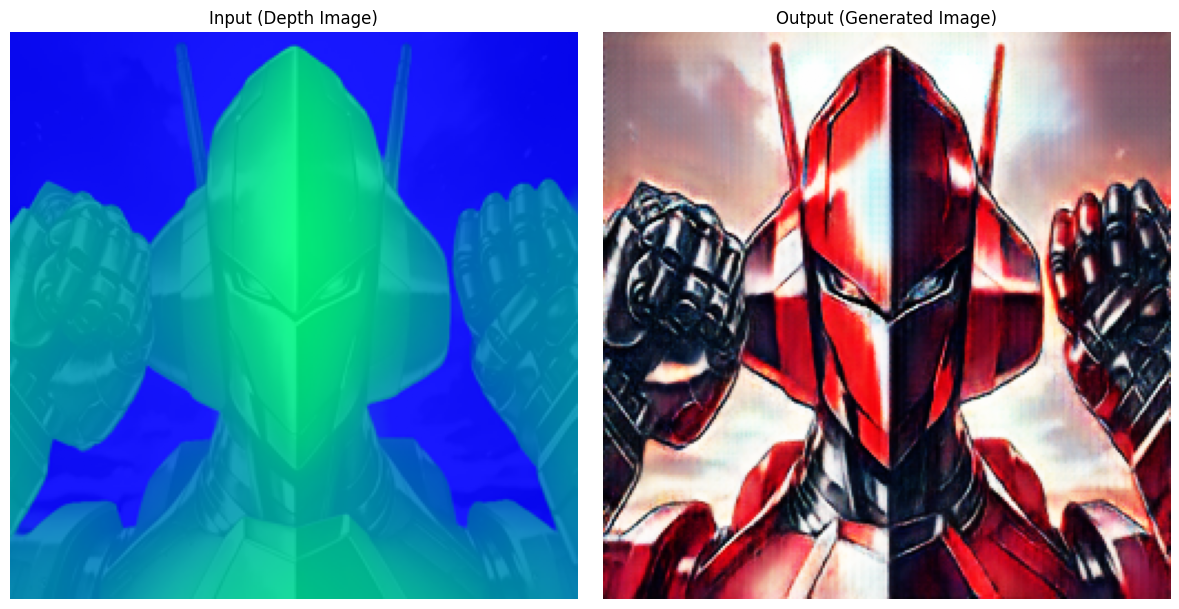

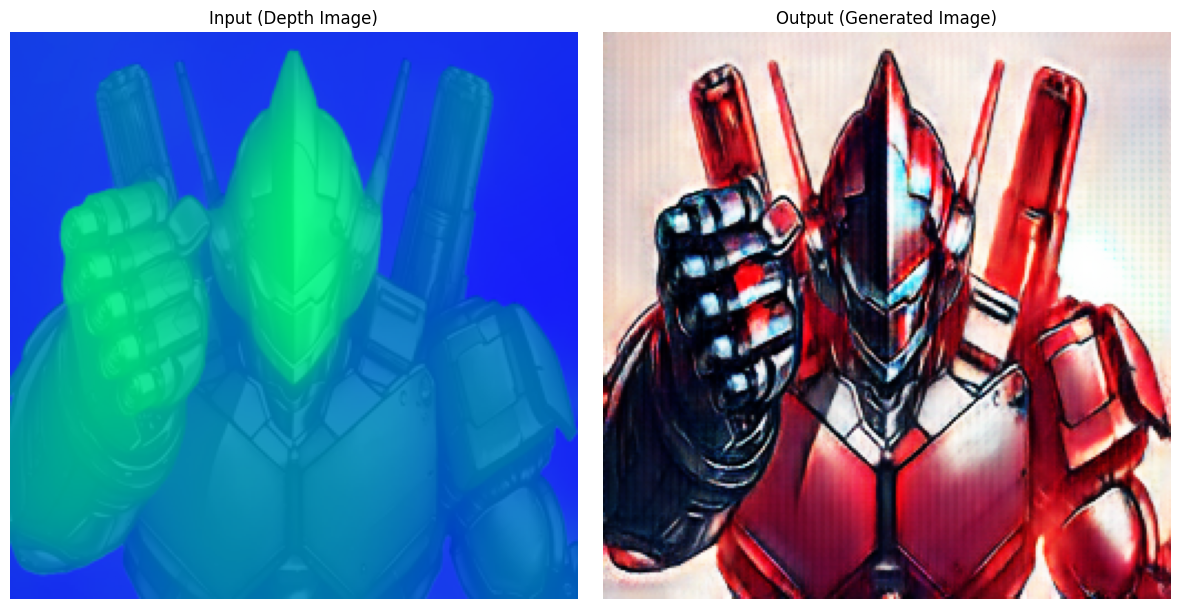

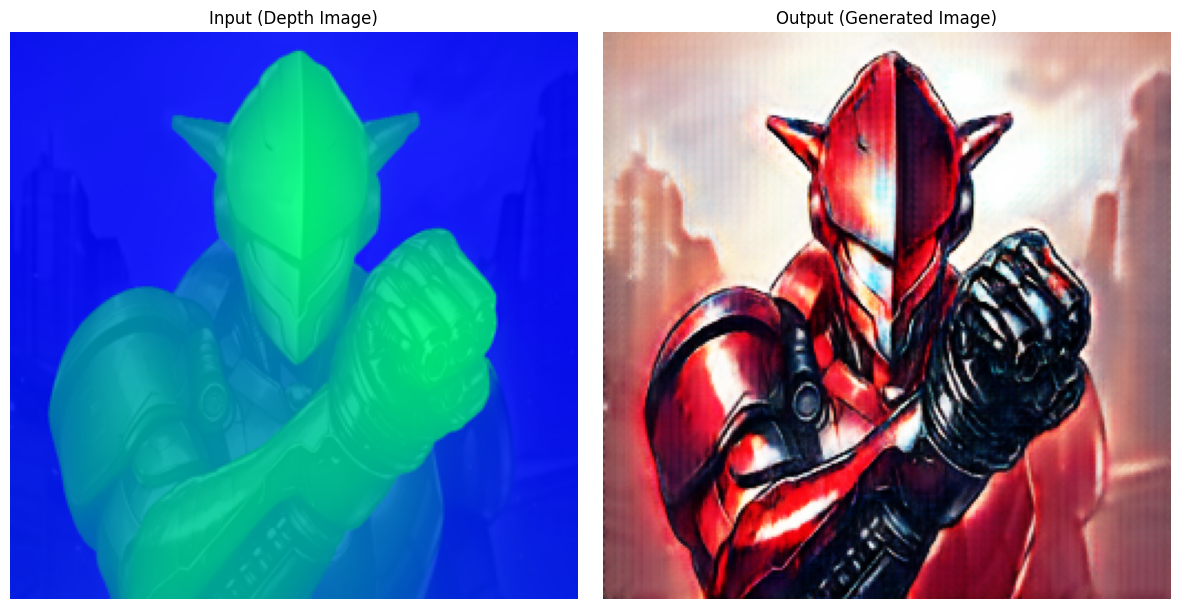

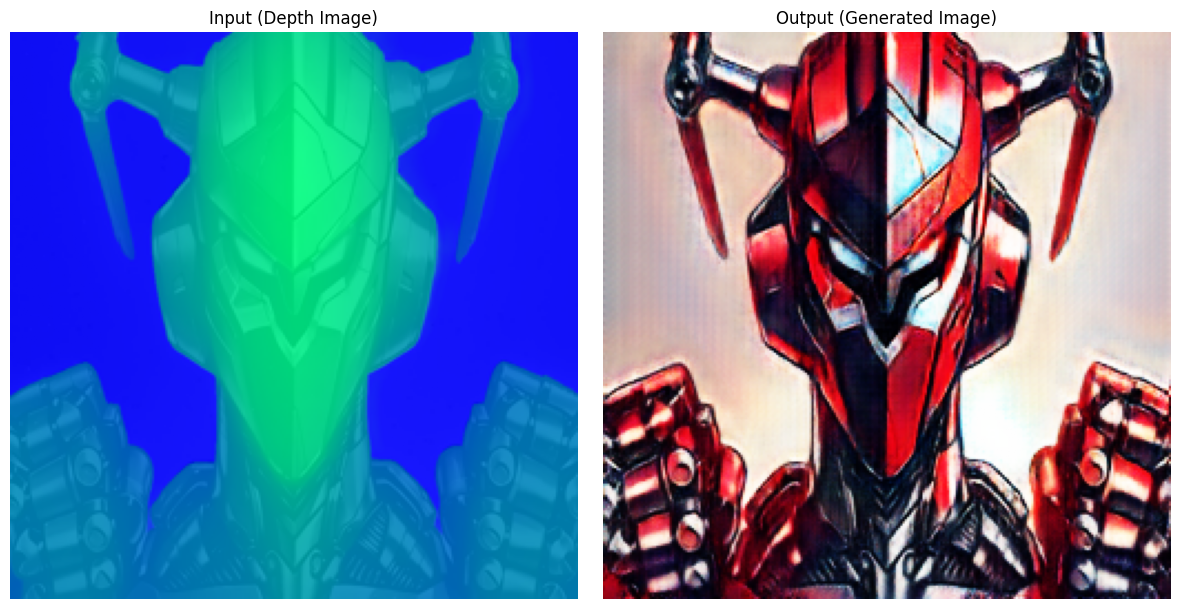

In [29]:
# Show results
show_results(5)

Found model: ./checkpoints/depth2image/latest_net_G_A.pth
Copied testA image to ../datasets/depth2image/custom_testA/custom.png
Testing testA → AtoB using model latest_net_G_A.pth
Running command: python test.py             --dataroot ../datasets/depth2image/custom_testA             --name depth2image             --model test             --no_dropout             --results_dir ../results/depth2image_fixed_testA             --model_suffix _A             --direction AtoB             --preprocess none
        
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../datasets/depth2image/custom_testA	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_

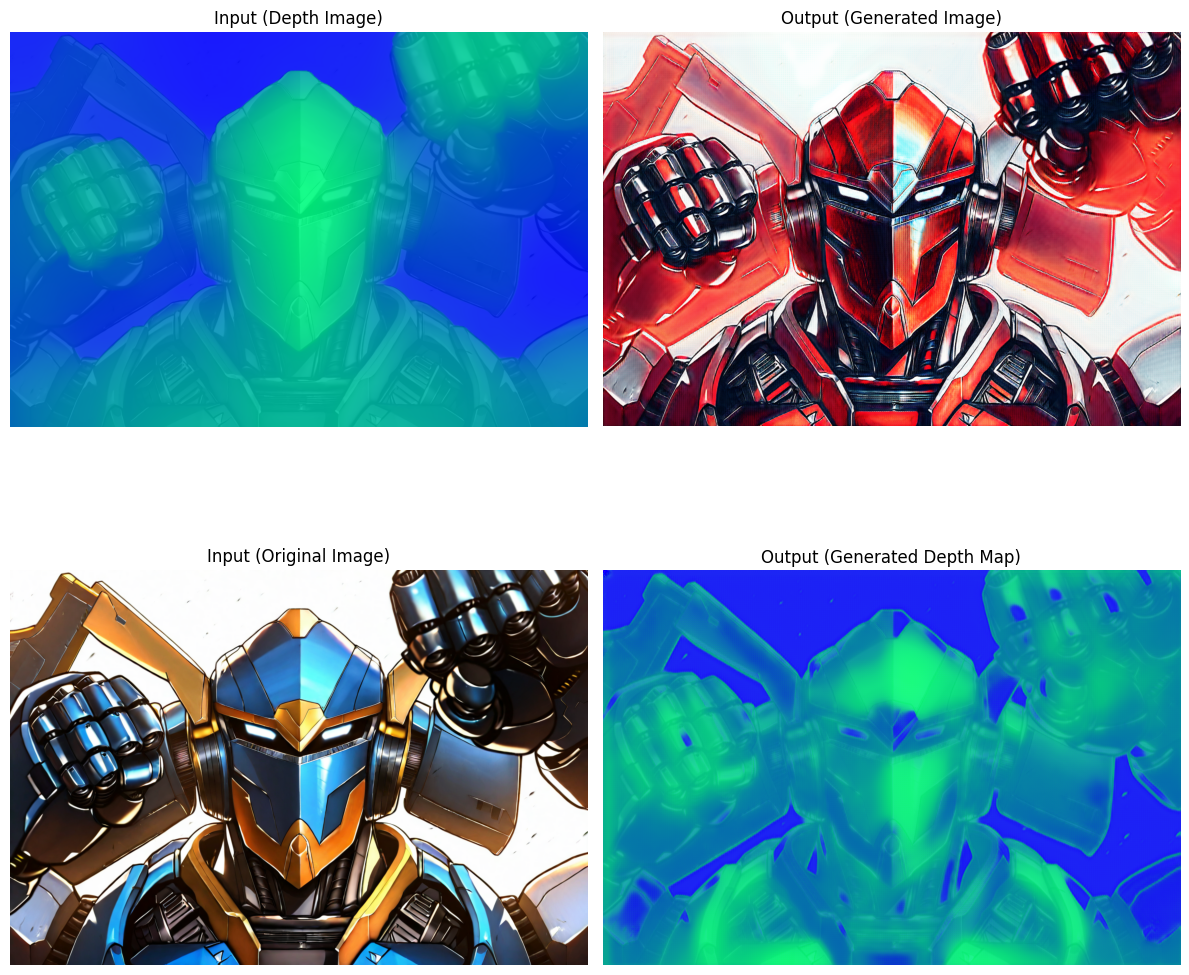

In [31]:
# Simple function to test both directions with correct model names
import os
import shutil
import glob
import matplotlib.pyplot as plt

def test_custom_image_with_correct_models():
    """
    Simplified function to test both directions using the correct model naming convention
    """
    results = []
    
    # Process one image from each test directory
    for test_dir, direction, model_name in [
        ('testA', 'AtoB', 'latest_net_G_A.pth'),  # depth → image
        ('testB', 'BtoA', 'latest_net_G_B.pth')   # image → depth
    ]:
        # Verify model exists
        model_path = f'./checkpoints/depth2image/{model_name}'
        if not os.path.exists(model_path):
            print(f"WARNING: Model file not found at {model_path}")
            print("Checking for available models...")
            models = glob.glob('./checkpoints/depth2image/*.pth')
            if models:
                print("Available models:")
                for m in models:
                    print(f"  {os.path.basename(m)}")
            continue
        else:
            print(f"Found model: {model_path}")
        
        # Get test image
        test_images = glob.glob(f'../datasets/depth2image/{test_dir}/*.png')
        if not test_images:
            print(f"No images found in {test_dir}")
            continue
            
        # Prepare custom directory
        custom_dir = f'../datasets/depth2image/custom_{test_dir}'
        os.makedirs(custom_dir, exist_ok=True)
        
        # Copy image
        image_path = test_images[0]
        custom_path = f'{custom_dir}/custom.png'
        shutil.copy(image_path, custom_path)
        print(f"Copied {test_dir} image to {custom_path}")
        
        # Extract only the part we need without the file extension
        # For latest_net_G_A.pth we just want _A
        model_suffix = '_' + model_name.split('_')[-1].replace('.pth', '')
        
        # Run test 
        print(f"Testing {test_dir} → {direction} using model {model_name}")
        cmd = f"""python test.py \
            --dataroot {custom_dir} \
            --name depth2image \
            --model test \
            --no_dropout \
            --results_dir ../results/depth2image_fixed_{test_dir} \
            --model_suffix {model_suffix} \
            --direction {direction} \
            --preprocess none
        """
        print(f"Running command: {cmd}")
        !{cmd}
        
        # Find output
        output_dir = f'../results/depth2image_fixed_{test_dir}'
        output_paths = glob.glob(f'{output_dir}/**/*.png', recursive=True)
        
        if output_paths:
            print(f"Found {len(output_paths)} output images")
            # Get first result
            output_path = output_paths[0]
            print(f"Using {output_path}")
            
            results.append({
                'test_dir': test_dir,
                'input_path': custom_path,
                'output_path': output_path
            })
        else:
            print(f"No output images found for {test_dir}")
    
    # Display results
    if results:
        plt.figure(figsize=(12, 6 * len(results)))
        
        for i, result in enumerate(results):
            plt.subplot(len(results), 2, 2*i + 1)
            input_img = plt.imread(result['input_path'])
            plt.imshow(input_img)
            
            if result['test_dir'] == 'testA':
                plt.title('Input (Depth Image)')
            else:
                plt.title('Input (Original Image)')
            
            plt.axis('off')
            
            plt.subplot(len(results), 2, 2*i + 2)
            output_img = plt.imread(result['output_path'])
            plt.imshow(output_img)
            
            if result['test_dir'] == 'testA':
                plt.title('Output (Generated Image)')
            else:
                plt.title('Output (Generated Depth Map)')
            
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No results to display")

# Run the test
test_custom_image_with_correct_models()